In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import functools
from einops import rearrange
import tqdm
import time
import optax

# Variational Auto-Encoders



<!-- > The **variational auto-encoder** is a generative model that works by compressing then decompressing data. -->

Around 2012-2014, the first breakthroughs in deep learning were arising, focusing on [classification](classifiers.ipynb). However, labelled datasets were expensive to curate. The question arose -- what can we learn from just *unlabelled data*? A solid answer is to learn a **generative model** -- neural networks that directly model the data they are trained on, and can generate new samples.

A classic generative modelling setting is that of image generation. We have a dataset of unlablled images, and we would like to train a neural network that, when queried, can generate images that match this dataset.

<!-- Generative modelling is best viewed through the lens of image generation. In a typical setting, we have a dataset of unlabelled images, and we would like to train a neural network model that, when queried, can generate images that match this dataset. -->

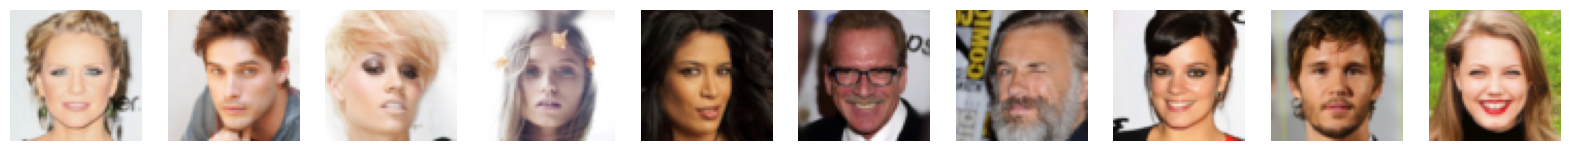

In [19]:
from jaxtransformer.utils.datasets import get_dataset

dataset = get_dataset('celebahq64', 64, is_train=True) # Normalized to [-1, 1].
dataset_valid = get_dataset('celebahq64', 64, is_train=False) # Normalized to [-1, 1].

batch, _ = next(dataset)
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow((batch[i] + 1) / 2, cmap='gray')
    ax.axis('off')

> **Fig:** Samples from the `CelebAHQ` dataset.

## Latent Variables

A **latent variable** is a piece of information that is not directly visible, but can be inferred from other observations. In our CelebA dataset, we only have access to the raw images. However, we know that faces can generally be described in terms of features such as hair color, eye shape, and so on. When we can represent a certain image as a dense vector of features, we call that vector a **latent representation**.

Of course, we have to discover the mapping from images to latent representations. One straightforward method of doing so is the **autoencoder**. An autoencoder consists of two networks -- an **encoder**, which maps an image to a latent variable, and a **decoder**, which maps the latent variable back to images. In most cases, the dimensionality of the latent vector is considerably smaller than the raw input. For example, an image may be `32x32x3` pixels, but its corresponding latent representation may be a `16`-dimensional vector. In this way, autoencoders are often seen as learning to *compress* data into a denser form (and then decompress it back).

To train an autoencoder, we can jointly train the encoder and decoder towards minimzing a **reconstruction objective**, often a standard L2 loss over pixels. Given an image input, the encoder network should form a latent representation, which recovers the original image when decoded.

![vae](vae-autoencoder.png)
> A basic autoencoder consisting of an encoder and decoder network. Both networks are jointly trained to recreate the original input.

## Variational Auto-Encoders

A naive autoencoder is not a generative model. While we are able to decode images from their latent representations, we don't any way to generate *new* images. The **variational auto-encoder (VAE)** will develop this capability, giving us our first generative model.

The key is that a variational auto-encoder also includes a specific constraint: **the distribution of latent variables should match a simple prior distribution**, often the unit Gaussian. If this constraint is satisfied, then the decoder portion of the network can be used to generate *novel* images, simply by querying this decoder with random Gaussian noise.

![vae](vae-decoder.png)
> To generate images, we sample *random* latent variables from a Gaussian prior, then pass them through our decoder.

Concretely, let's name the input image as `x` and the latent variable as `z`. We want to learn an encoder `q_\theta(z|x)`, and a decoder `p_\theta(x|z)`. We will parameterize the encoder and decoder as neural networks which output the mean and variance of a Gaussian distribution. The full VAE objective can now be written as:

$$
L(\theta, x) = \underbrace{E_{z \sim q_\theta(z|x)}[\log p_\theta(x|z)]}_{\text{Reconstruction Objective}} + \underbrace{KL(q_\theta(z|x) || q(z))}_{\text{Prior-Matching Objective}}
$$

where $q(z)$ is an uninformtive prior, often the Gaussian distribution.

## Implementation: VAE on CelebAHQ

We're almost ready to implement a simple VAE. First, let's go over a few analytical properties of the Gaussian, so we can translate them into code.

<!-- For the reconstruction objective, note that the log-probability of a point `x` under a Gaussian parameterized by mean `mu` and variance `sigma` is: -->
For the reconstruction objective, note that the negative log-likelihood of a point $x$ under a Gaussian parameterized by mean $\mu$ and standard deviation $\sigma$ is:

$$
- \log p(x) = \log(2 \pi) + \log(\sigma) + \frac{(x - \mu)^2}{2 \sigma^2}.
$$

where the constant $\log(2 \pi)$ term can be dropped during optimization.

In [ ]:
def reconstruction_loss(x, mean, log_std):
   return log_std + jnp.square((x-mean)/jnp.exp(log_std))

If this looks suspiciously like the mean-squred error loss, you are on the right track. MSE loss is often justified as maximzing the log-probability of a datapoint under a Gaussian with unit variance.

For the prior matching objective, we would like to minimize the KL divergence between `q(z|x)` and the unit Gaussian `q(x)`. Remember that `q(z|x)` is also a Gaussian, parametermized by mean and variance. Thankfully, there's a simple analytical form to this objective we can arrive at. For now, we will just take it for granted -- there will be a proper derivation in a later section.

In [ ]:
def prior_matching_loss(mean, log_std):
    return jnp.exp(log_std) + jnp.square(mean) - 1 - log_std

With those key equations in mind, let's implement our VAE. We'll again use the `jaxtransformer` library to define a transformer backbone for the encoder and decoder models. We will process images using a patch embedding, and use an embedding token to represent the final output of the encoder. 

In [20]:
from jaxtransformer.transformer import TransformerBackbone
from jaxtransformer.modalities import PatchEmbed, PatchOutput, ClassifierOutput, get_2d_sincos_pos_embed
from jaxtransformer.utils.train_state import TrainState

class Encoder(nn.Module):
    hidden_size: int
    z_dim: int
    patch_size: int
    num_patches: int

    @nn.compact
    def __call__(self, x):
        x = PatchEmbed(patch_size=self.patch_size, hidden_size=self.hidden_size)(x)
        x = x + get_2d_sincos_pos_embed(None, self.hidden_size, self.num_patches)
        embed_token = nn.Embed(num_embeddings=1, features=self.hidden_size)(jnp.zeros((x.shape[0], 1), dtype=jnp.int32))
        x = jnp.concatenate([embed_token, x], axis=1)
        x = TransformerBackbone(depth=4, num_heads=4, hidden_size=self.hidden_size, 
            use_conditioning=False, use_causal_masking=False, mlp_ratio=4)(x)
        x = nn.LayerNorm()(x)
        x = nn.Dense(features=self.z_dim * 2)(x[:, 0, :])
        mean, log_std = jnp.split(x, 2, axis=-1)
        return mean, log_std
    
class Decoder(nn.Module):
    hidden_size: int
    patch_size: int
    num_patches: int
    channels_out: int

    @nn.compact
    def __call__(self, z):
        x = nn.Dense(features=self.hidden_size)(z)
        x = jnp.tile(x[:, None, :], (1, self.num_patches, 1))
        x = x + get_2d_sincos_pos_embed(None, self.hidden_size, self.num_patches)
        x = TransformerBackbone(depth=4, num_heads=4, hidden_size=self.hidden_size, 
            use_conditioning=False, use_causal_masking=False, mlp_ratio=4)(x)
        x = nn.LayerNorm()(x)
        x = PatchOutput(patch_size=self.patch_size, channels=self.channels_out*2)(x)
        mean, log_std = jnp.split(x, 2, axis=-1)
        return mean, log_std

class VAE(nn.Module):
    hidden_size: int = 256
    z_dim: int = 64
    patch_size: int = 8
    input_side_len: int = 64
    input_channels: int = 3

    def setup(self):
        num_patches = (self.input_side_len // self.patch_size)**2
        self.encoder = Encoder(self.hidden_size, self.z_dim, self.patch_size, num_patches)
        self.decoder = Decoder(self.hidden_size, self.patch_size, num_patches, self.input_channels)

    def __call__(self, x, rng):
        z_mean, z_log_std = self.encoder(x)
        noise = jax.random.normal(rng, z_mean.shape)
        z = z_mean + jnp.exp(z_log_std) * noise
        x_mean, x_log_std = self.decoder(z)
        return x_mean, x_log_std, z_mean, z_log_std
    
    def encode(self, x):
        return self.encoder(x)[0]
    
    def decode(self, z):
        return self.decoder(z)[0]

@jax.jit
def loss_fn(params, x, rng):
    x_mean, x_log_std, z_mean, z_log_std = VAE().apply({'params': params}, x, rng)
    reconstruction_loss = 0.5 * jnp.mean(jnp.sum(((x - x_mean)/jnp.exp(x_log_std))**2 + x_log_std, axis=(1,2,3)))
    kl_loss = 0.5 * jnp.mean(jnp.sum(jnp.exp(z_log_std) + z_mean**2 - 1 - z_log_std, axis=-1)) * 100
    info = {'reconstruction_loss': reconstruction_loss, 'kl_loss': kl_loss, 'avg_x_std': jnp.mean(jnp.exp(x_log_std)), 'avg_z_std': jnp.mean(jnp.exp(z_log_std))}
    return reconstruction_loss + kl_loss, info

In [21]:
# Generic model setup code.
model = VAE()
tx = optax.adam(learning_rate=1e-4)
rng = jax.random.PRNGKey(0)
train_state = TrainState.create(rng, model, (jnp.ones((1, 64, 64, 3)), rng), tx)

@jax.jit
def update_fn(train_state, x):
    vae_key, rng = jax.random.split(train_state.rng)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, infos), grad = grad_fn(train_state.params, x, vae_key)
    updates, new_opt_state = train_state.tx.update(grad, train_state.opt_state, train_state.params)
    new_params = optax.apply_updates(train_state.params, updates)
    new_train_state = train_state.replace(params=new_params, opt_state=new_opt_state, rng=rng)
    return new_train_state, (loss, infos)

def plot(losses, reconstruction_losses, kl_losses, valid_losses, x_std, z_std):
    fig, axs = plt.subplots(1, 5, figsize=(18, 3))
    steps = np.arange(0, len(losses) * 300, 300)
    axs[0].plot(steps, losses, label='Train')
    axs[0].plot(steps, valid_losses, label='Valid')
    axs[0].legend()
    axs[0].title.set_text('Total Loss')
    axs[1].plot(steps, reconstruction_losses, label='Train')
    axs[1].legend()
    axs[1].title.set_text('Reconstruction Loss')
    axs[2].plot(steps, kl_losses, label='Train')
    axs[2].legend()
    axs[2].title.set_text('KL Loss')
    axs[3].plot(steps, x_std, label='Train')
    axs[3].legend()
    axs[3].title.set_text('X Std')
    axs[4].plot(steps, z_std, label='Train')
    axs[4].legend()
    axs[4].title.set_text('Z Std')
    # axs[0].set_ylim([0, 1000])
    # axs[1].set_ylim([0, 1000])
    # axs[2].set_ylim([0, 100])
    plt.show()

In [ ]:
rng = jax.random.PRNGKey(0)
losses, reconstruction_losses, kl_losses, x_std, z_std, valid_losses = [], [], [], [], [], []
for i in tqdm.tqdm(range(100000)):
    rng, batch_key = jax.random.split(rng)
    inputs, _ = next(dataset)
    train_state, (loss, infos) = update_fn(train_state, inputs)
    if i % 300 == 0:
        inputs, _ = next(dataset_valid)
        valid_loss, _ = loss_fn(train_state.params, inputs, train_state.rng)
        reconstruction_losses.append(float(infos['reconstruction_loss']))
        kl_losses.append(float(infos['kl_loss']))
        x_std.append(float(infos['avg_x_std']))
        z_std.append(float(infos['avg_z_std']))
        losses.append(float(loss))
        valid_losses.append(float(valid_loss))
        print(losses[-1], reconstruction_losses[-1], kl_losses[-1], x_std[-1], z_std[-1])

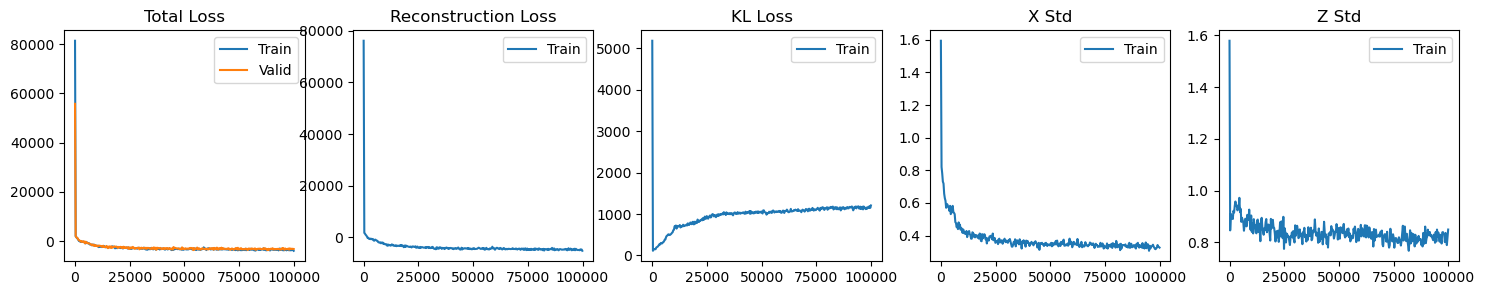

In [23]:
plot(losses, reconstruction_losses, kl_losses, valid_losses, x_std, z_std)

Notice the tradeoff between reconstruction loss and the prior-matching loss. Training a VAE is a balancing act -- we want to encode information into the latent variable which is helpful for reconstruction, yet the prior-matching loss penalizes information.

We can also see the standard deviation of our decoder decrease over time, which is a good sanity check. A lower standard deviation means the decoder is more confident about the images it produces, i.e. the reconstructions will be higher quality.

Now, let's examine some reconstructions. We will sample some ground-truth images from our dataset, encode them, then decode them back out.

Reconstruction error: 0.06656577


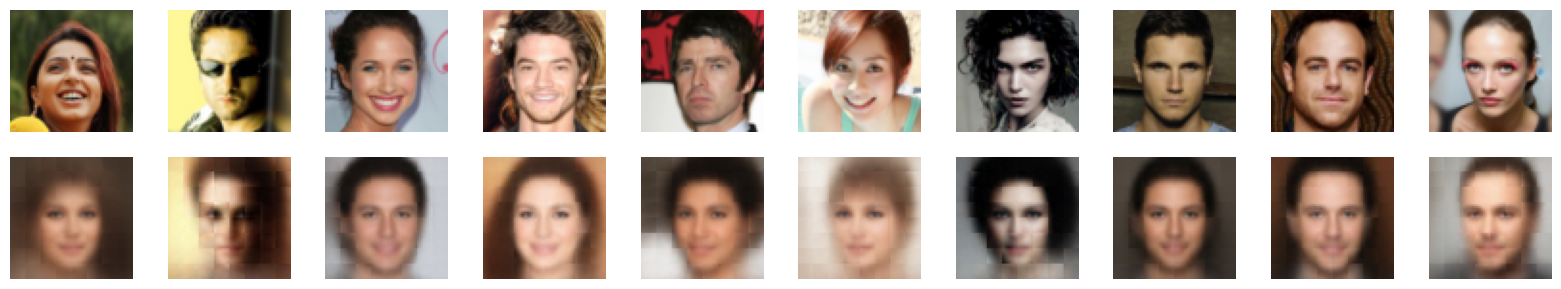

In [26]:
true_images, _ = next(dataset)
z = model.apply({'params': train_state.params}, true_images, method=model.encode)
reconstruction = model.apply({'params': train_state.params}, z, method=model.decode)
print("Reconstruction error:", np.mean((true_images - reconstruction) ** 2))

true_images = (np.array(true_images).astype(np.float32) + 1) / 2
reconstruction = (np.array(reconstruction).astype(np.float32) + 1) / 2
fig, axs = plt.subplots(2, 10, figsize=(20, 3.5))
for i in range(10):
    axs[0, i].imshow(true_images[i], cmap='gray')
    axs[1, i].imshow(reconstruction[i], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].axis('off')

Not bad! The general features of each image are preserved in the recreation.

We can now sample generations 

-0.09765625 1.0039062


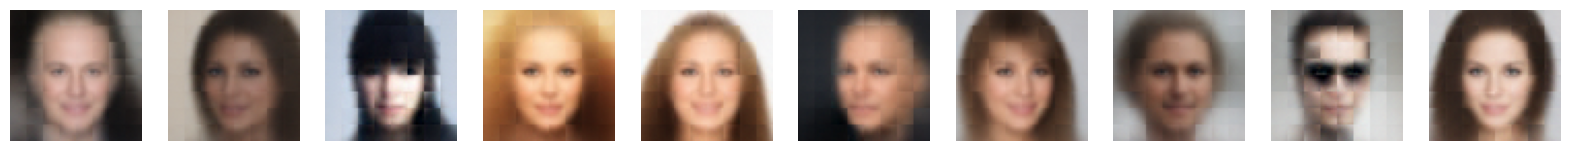

In [27]:
z = jax.random.normal(jax.random.PRNGKey(0), (10, 64))
img = model.apply({'params': train_state.params}, z, method=model.decode)
img = (np.array(img).astype(np.float32) + 1) / 2
print(np.min(img), np.max(img))

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axs):
    ax.imshow(img[i], cmap='gray')
    ax.axis('off')

You'll notice that in both reconstruction and generation, the outputs are quite blurry. **Blurriness is a consistent weakness of VAE generations**. The reason for this is twofold:
- First, the prior-matching term in the VAE encourages each latent variable to contain as little information as possible. This means that there will always be some uncertainty about the original image, even when given its matching latent representation.
- Second, we parameterize the decoder as a Gaussian distribution. Gaussian distributions maximize log-likelihood by matching the *mean* of a distribution. If the ground-truth pixels take on a bimodal distribution of `0` or `1`, a Gaussian will predict the mean of `0.5`. For images in pixel space, this results in blurriness. **Uncertainty in pixel space results in blurry generation**.

## Derivation of Analytical KL Loss

For arbitrary probabiltiy distributions, measuring the KL divergence involves either an intractable integral, or approximating the KL with many samples. However for certain distributions, notably Gaussians, the true KL divergence can be computed analytically. This technique is used to derive the KL regularization loss in the VAE. We wish to calculate the KL divergence between a Gaussian `q(z|x)` and the unit Gaussian `p(z)`.

Starting from the definition of KL divergence:

$$
\begin{align}
KL & = E_q[ \log q(z|x) - \log p(z)] \\
& = E_q[ -\log(2 \pi) - \log(\sigma) - \frac{(z - \mu)^2}{2 \sigma^2} - \log p(z)] \qquad \text{(Log-prob of Gaussian.)}  \\
& = E_q[ -\log(2 \pi) - \log(\sigma) - \frac{(z - \mu)^2}{2 \sigma^2} + \log(2 \pi) - \frac{z^2}{2}] \qquad \text{(Log-prob of unit Gaussian.)} \\
& = \underbrace{E_q[ - \log(2 \pi) - \log(\sigma) + \log(2 \pi)]}_{\text{Expectation 1}} + \underbrace{E_q \left[ - \frac{(z - \mu)^2}{2 \sigma^2} \right] }_{\text{Expectation 2}} + \underbrace{E_q \left[ - \frac{z^2}{2} \right]}_{\text{Expectation 3}}
\end{align}
$$

Let's deal with each of these three expectation terms one-by one. For the first expectation, there are no `z` terms, so we can drop the expectation entirely.

$$
E_q[ - \log(2 \pi) - \log(\sigma) + \log(2 \pi)] = E_q[-\log(\sigma)] = -\log(\sigma) = -(1/2) \log (\sigma^2)
$$

For the second expectation, we make use of the fact that for a Gaussian, $E_q[(z-\mu)^2] = \sigma^2$ (variance).

$$
E_q \left[ -\frac{(z - \mu)^2}{2 \sigma^2} \right] = -\frac{\sigma^2}{2 \sigma^2} = -(1/2)
$$

For the third expecation, we again make use of analytical variance. Remember that $\sigma^2 = E[z^2] - E[z]^2 = E[z^2] - \mu$.

$$
E_q \left[ - \frac{z^2}{2} \right] = -(1/2) E_q[z^2] = (1/2)(\sigma^2 + \mu^2)
$$

Putting the three terms back together, we arrive at the final analytical KL term:

$$
KL(q(z|x) || p(z)) = (1/2) (-\log(\sigma^2) - 1 + \sigma^2 + \mu^2)
$$

To sanity check, let's verify that the minimizer of this loss occurs when $\mu = 0$ and $\sigma = 1$.

$$
(d/d \mu) [-\log(\sigma^2) - 1 + \sigma^2 + \mu^2] = 2 \mu \qquad \text{Minimum at} \; \mu = 0. \\
(d/d \sigma) [-\log(\sigma^2) - 1 + \sigma^2 + \mu^2] = 2 \sigma - 2/\sigma \qquad \text{Minimum at} \; \sigma = 1.
$$

## Can MSE loss be used for reconstruction loss?

Yes, with some caveats. Many VAE implementations will just use an MSE loss for the reconstruction term, rather than the Gaussian log-likelihood we use in our implementation. The key intution is that MSE loss is just a special case of the Gaussian log-likelihood, with variance set to 1. Learning the variance lets the model make a more accurate prediction, so it's the more ideal thing to do.

## How should the tradeoff between reconsturction and KL be tuned?

In our VAE implentation, we have a hyperparameter `beta` that trades off between the reconstruction loss and the prior-matching loss. This hyperparameter is not present in the original VAE derivation. However, note that the relative magnitudes of the reconstruction and prior-matching terms depend on the *dimensionality* of each space. If we sum over channels vs. taking the mean, for example, our weighting will change. Thus, my current reccomendation is to simply find a good `beta` term empirically. These concepts are covered in more detail in the Beta-VAE paper [].

## KL-Regularization is performed elementwise, *not* batchwise.

A common misconception of the VAE is that the prior-matching term encourages the marginal distribution of latent variables to look Gaussian. In other words, a batch of encoded latents should roughly resemble the unit Gaussain. This is a misunderstanding -- the prior-matching term encourages **eacb indivudual latent variable to look Gaussian, regardless of the other latents in the batch**. 

## Why are VAEs often blurry?

In the end, the mismatch between *pixelwise distance* and *perceptual distance* causes blurriness. In the stnadard VAE formulation, we assume that our decode follows a Gaussian distribution. Gaussian distributions maximize log-likelihood by matching the *mean* of a distribution. Thus, if a pixel could possible take on the values of `0` or `1`, the optimal Gaussian predictor will center around `0.5`, resulting in blurriness.

## Derivation of VAE from Evidence Lower Bound (ELBO).

## The Reparameterization Trick